In [1]:
import os, copy, sys
sys.path.extend(['../..', '../../../..'])
import trkd_roi_analysis as tra
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
from matplotlib.colors import colorConverter
import matplotlib as mpl
import matplotlib.patches as mpatches

In [2]:
# name for mouse_df
mouse_df_fnm = '../../../../mouse_df.csv'
mouse_df, _, _ = tra.set_up_mouse_info(mouse_df_fnm)

All mice:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Mice with all of sessions 1-3 : [ 1  3  4  6  7  8  9 10 11 12 13]


<h2>Load data</h2>

In [3]:
mask_fnm = '../../data/nway_union_tmasks__mice_4_6.h5'
nway_union_tmasks_df = pd.read_hdf(mask_fnm)
perm_mask_fnm = '../../data/nway_perm_tmasks__mice_4_6.h5'
nway_perm_tmasks_df = pd.read_hdf(perm_mask_fnm)

In [4]:
nway_union_tmasks_df

,mouse_n,layer,compartment,masks
0,4,L5,Somas,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,6,L2/3,Dendrites,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [5]:
nway_perm_tmasks_df

,mouse_n,layer,compartment,sess_perm,masks
0,4,L5,Somas,"[3, 2, 1]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,4,L5,Somas,"[2, 1, 3]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,6,L2/3,Dendrites,"[1, 2, 3]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,6,L2/3,Dendrites,"[3, 2, 1]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


<h2>Main cell to plot data</h2>

In [8]:
%%time

mouse_ns = [6,4]

compartments = {'soma':'Somas', 'dend':'Dendrites'}
sess_ns = np.array([1,2,3])

pdf_fnm = '../../plots/supp-fig-7.pdf'

with PdfPages(pdf_fnm) as pdf:
    fig, ax = plot_figure(mouse_ns, sess_ns, nway_union_tmasks_df, nway_perm_tmasks_df)
    pdf.savefig()
    plt.close()    

mouse  6
mouse  4
CPU times: user 9.77 s, sys: 1.01 s, total: 10.8 s
Wall time: 8.87 s


mouse  6
mouse  4
CPU times: user 263 ms, sys: 4.52 ms, total: 267 ms
Wall time: 263 ms


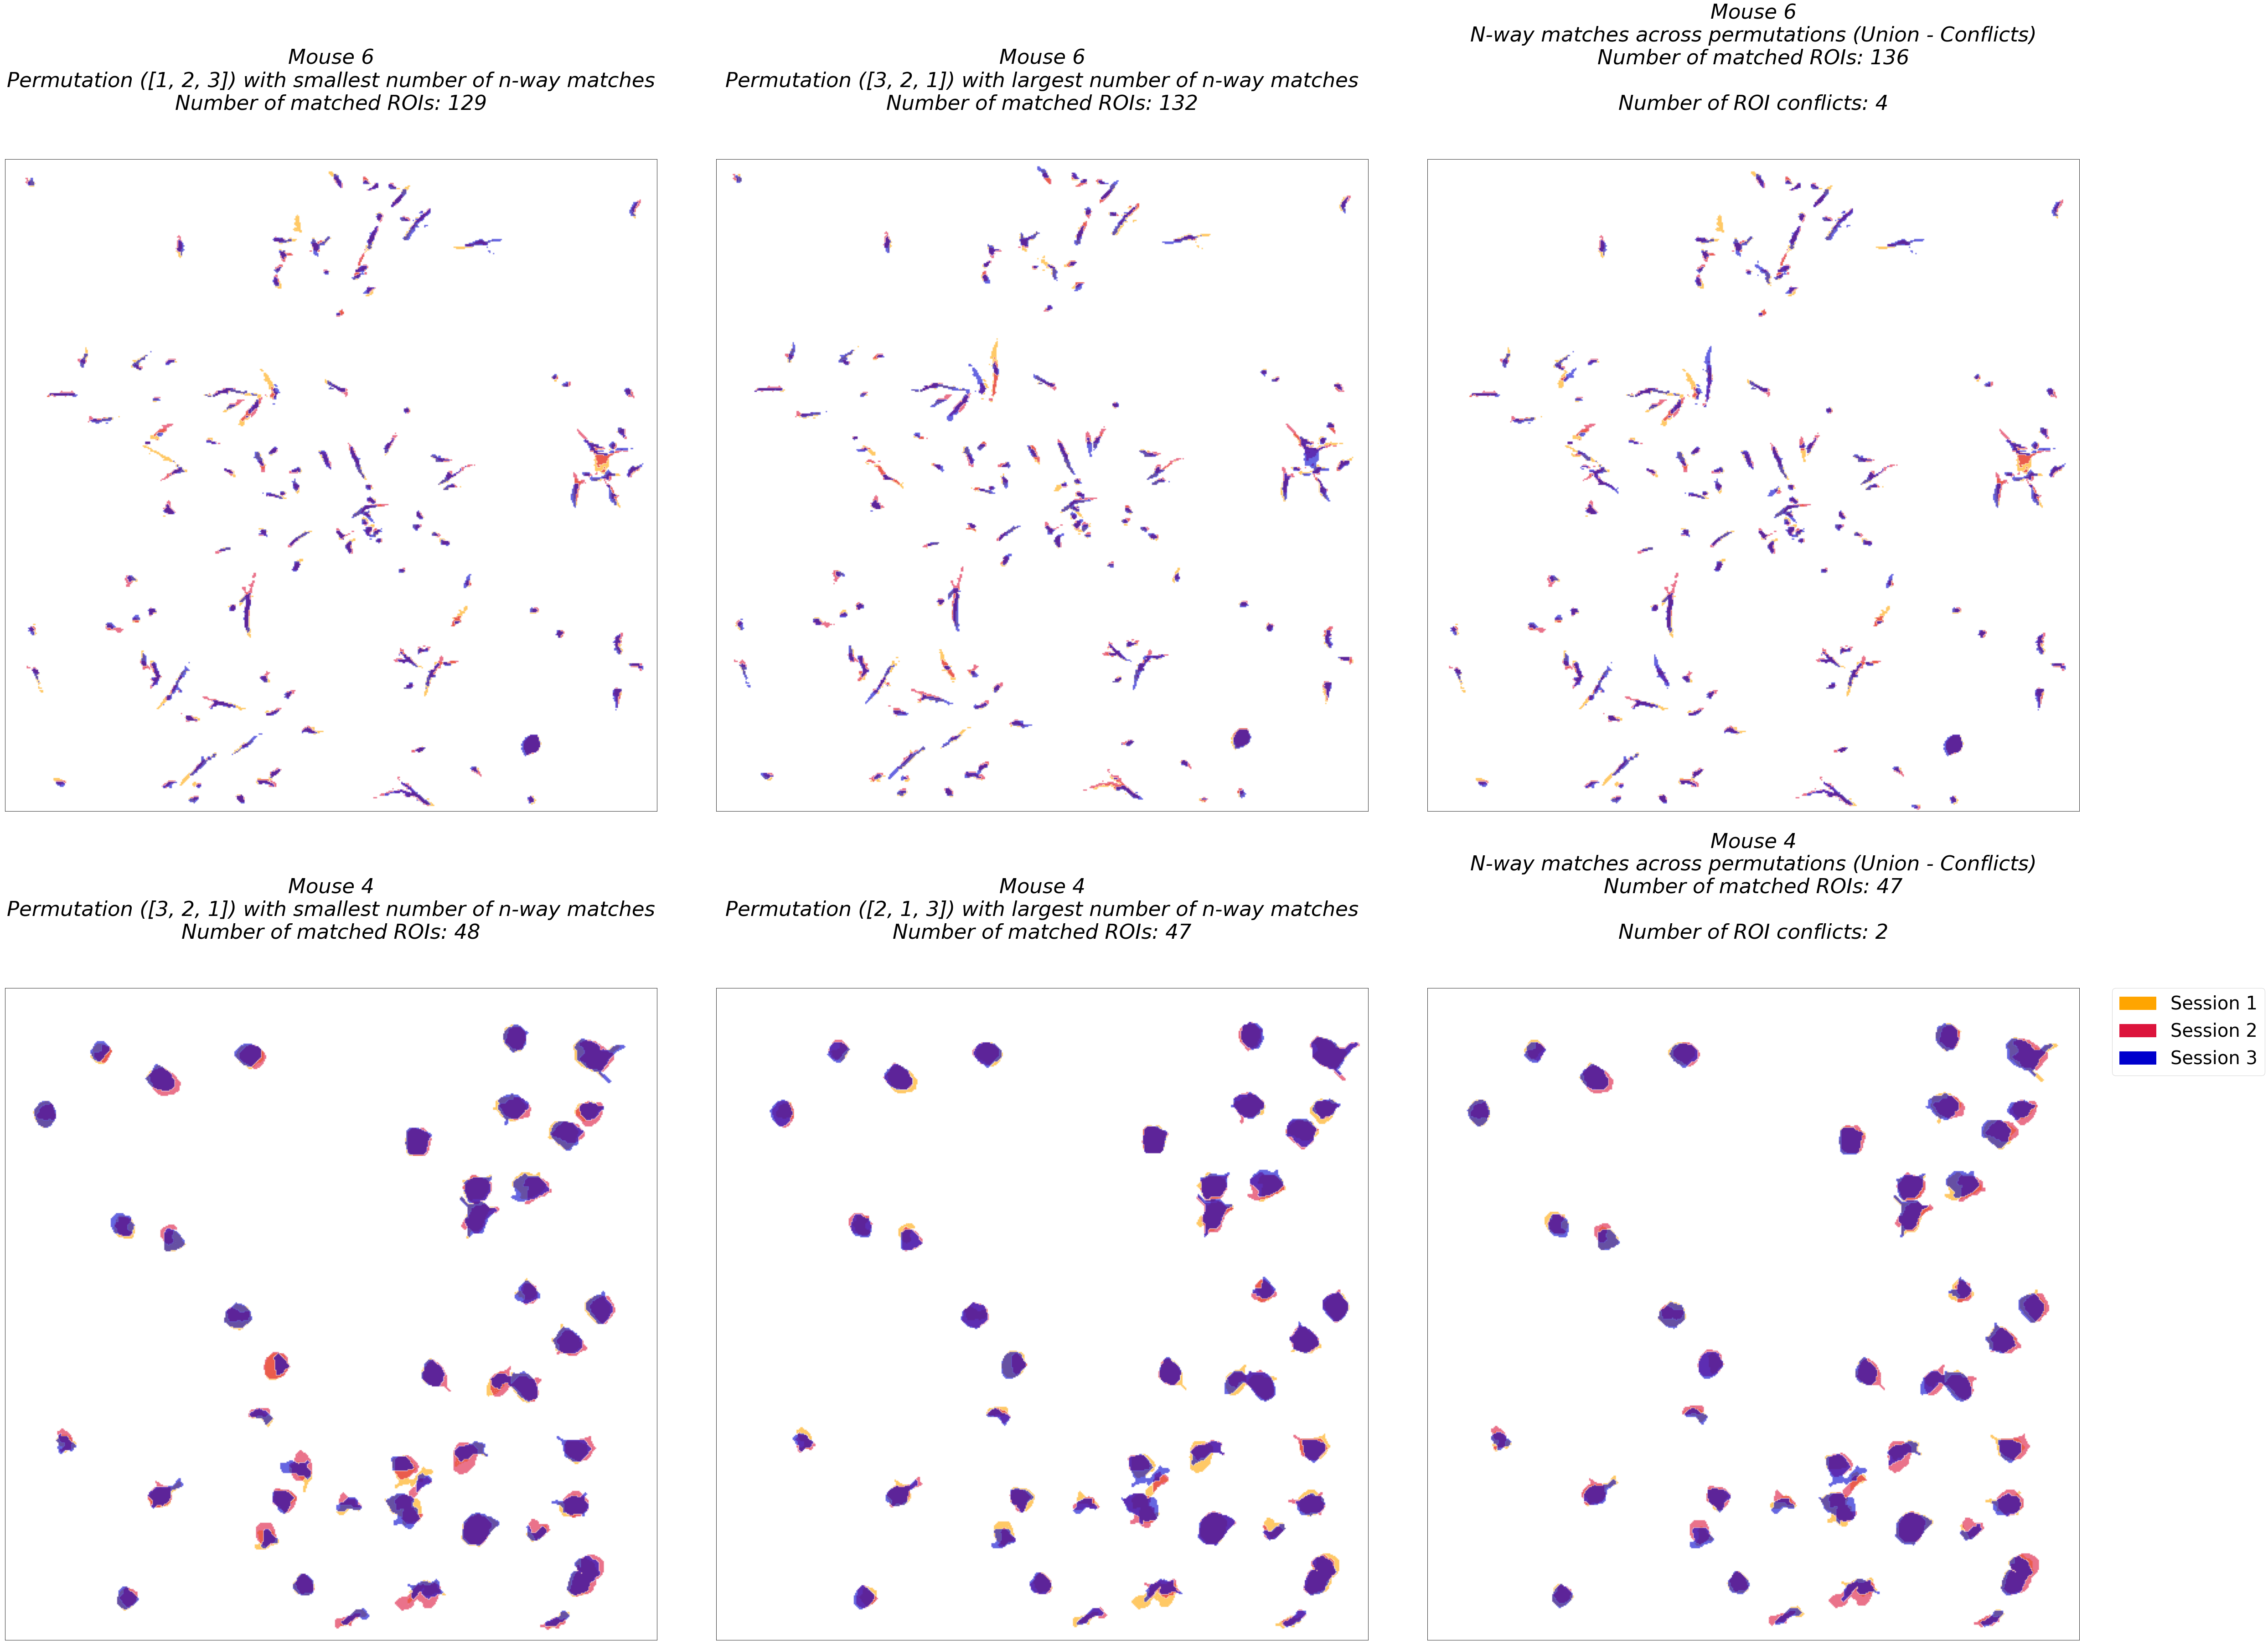

In [7]:
%%time

mouse_ns = [6,4]

compartments = {'soma':'Somas', 'dend':'Dendrites'}
sess_ns = np.array([1,2,3])

fig, ax = plot_figure(mouse_ns, sess_ns, nway_union_tmasks_df, nway_perm_tmasks_df)

**Caption draft**: Dendritic ROI matches vary greatly with session ordering compared to somatic ROI matches.

**(A)** [[A is top row]] An example L2/3-S with matched ROIs across sessions. The order in which the images are aligned can affect the number of matched ROIs.  Different orderings can also create conflicting matches, in that 1 ROI in one session can be matched to more than 1 ROI from another session, depending on the ordering. Note that that some ROIs do not appear to overlap despite the fact that putative pairwise matchings with an overlap of less than 30\% were rejected.  This erroneous perception arises in part due to the segmentation algorithms, which may label 2 apparently disconnected regions as 1 ROI, and in part due to the image alignment algorithm, which can only align two sessions at a time. (Left) Permutation with the smallest number of matched ROIs.  (Middle) Permutation with the largest number of matched ROIs. (Right) By combining all matches across all sessions and removing conflicting matches (4 here), more ROIs can be matched than even the ordering with the largest number of matches.

**(B)** Same as (A), but for somata. The variation in number of matched ROIs across session orderings for somata was generally far less than that for dendrites.  Here, all permutations (left and middle), as well as the combination of all permutations with conflicts removed (right), resulted in 47 or 48 matched ROIs.  However, note that, due to conflicting matches, combining matched ROIs and removing the conflicts can in fact result in fewer ROIs than the maximal permutation (or, in principle, than the minimal permutation).  2 conflicts arose in this particular case


<h2>Plotting function</h2>

In [6]:
def plot_figure(mouse_ns, sess_ns, nway_union_tmasks, nway_perm_tmasks_df):

    newcolor = 'orange'
    newcolor1 = 'crimson'
    colors = [mcolors.CSS4_COLORS[newcolor],
              mcolors.CSS4_COLORS[newcolor1],
              mcolors.CSS4_COLORS['mediumblue']]
    levels=256
    alphas = 0.6*np.ceil(np.linspace(0, 0.8, levels+3))
    
    n_rois_dict = {4:[48, 47, 47, 2],
                   6:[129, 132, 136, 4]}
    
    sess_natural_order = copy.deepcopy(sess_ns)
    sess_natural_order.sort()
    sess_nat_str = ', '.join(sess_natural_order.astype(str))


    
    fig, ax = plt.subplots(2,3, figsize=(70,50), constrained_layout=True)
    for plt_row, mouse_n in enumerate(mouse_ns):
        print('mouse ', mouse_n)

        mask = nway_union_tmasks_df['mouse_n']==mouse_n
        nway_tmasks = nway_union_tmasks_df[mask]['masks'].values[0]
        plane = mouse_df[mouse_df['mouse_n']==mouse_n]\
                    ['plane'].unique()[0]
        line = mouse_df[mouse_df['mouse_n']==mouse_n]\
                    ['line'].unique()[0]
        compartment = compartments[plane]
        layers = {'L23-Cux2':'L2/3', 'L5-Rbp4':'L5'}
        layer = layers[line]

        for plt_col in [0,1,2]:
            if plt_col<2:
                mask = nway_perm_tmasks_df['mouse_n']==mouse_n
                df = nway_perm_tmasks_df[mask].iloc[plt_col:plt_col+1]
                nway_tmasks = df['masks'].values[0]
                sess_perm = df['sess_perm'].values[0]
            elif plt_col==2:
                mask = nway_union_tmasks_df['mouse_n']==mouse_n
                nway_tmasks = nway_union_tmasks_df[mask]['masks'].values[0]
            plt.sca(ax[plt_row, plt_col])
            for k,_ in enumerate(sess_ns):
                cmap = mpl.colors.LinearSegmentedColormap.from_list(
                    'my_cmap',['white', colors[k]],N=levels)
                cmap._init()
                cmap._lut[:,-1] = alphas
                im = plt.imshow(nway_tmasks[k,:], cmap=cmap)
            
            plt.xticks([], [])
            plt.yticks([], [])
            titles = ['Mouse {}\n'.format(mouse_n) +
                      'Permutation ({}) with smallest number of n-way matches\n'.format(sess_perm) +
                      'Number of matched ROIs: {}\n\n'.format(n_rois_dict[mouse_n][plt_col]),
                      'Mouse {}\n'.format(mouse_n) +
                      'Permutation ({}) with largest number of n-way matches\n'.format(sess_perm) + 
                      'Number of matched ROIs: {}\n\n'.format(n_rois_dict[mouse_n][plt_col]),
                      'Mouse {}\n'.format(mouse_n) +
                      'N-way matches across permutations (Union - Conflicts)\n' +
                      'Number of matched ROIs: {}\n\n'.format(n_rois_dict[mouse_n][plt_col]) +
                      'Number of ROI conflicts: {}\n\n'.format(n_rois_dict[mouse_n][plt_col+1])]
            plt.title(titles[plt_col], fontsize=45, fontstyle='italic')
            if plt_row == 1 and plt_col == 2:
                patches = [ mpatches.Patch(color=colors[i], label="Session {l}".format(l=sess_ns[i]) ) 
                           for i in range(len(sess_ns)) ]
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=40)

    return fig, ax